## STATS 601 Project workspace

### Import Libraries
Note that pandas version has to be 1.4.x or higher and python version has to be 3.8.x or higher in order to read the pickle file.

In [1]:
!pip3 install numpy==1.22.1
!pip3 install pandas==1.4.1
!pip3 install matplotlib
!pip3 install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=c4ad60d865459249f9be607f052aac25505d1a2c663de883df1d7b502be74492
  Stored in directory: \\engin-labs.m.storage.umich.edu\tywwyt\windat.v2\appdata\local\pip\cache\wheels\9b\13\01\6f3a7fd641f90e1f6c8c7cded057f3394f451f340371c68f3d
Successfully built sklearn


In [4]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit

# !pip3 install bayesian-optimization
# import hyperparam
import critic

### Read data from pickle file and visualize
*log_pr* is the log prices of the ten assets in the past 6 months. *volu* is the trading volume of the ten assets in the past 6 months. 

In [5]:
# Load the data frames

log_pr = pd.read_pickle("./log_price.df")
volu = pd.read_pickle("./volume_usd.df")

array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>,
       <AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>],
      dtype=object)

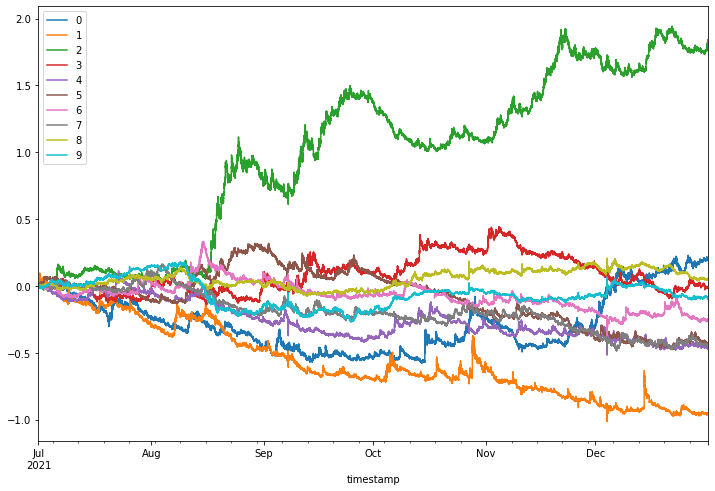

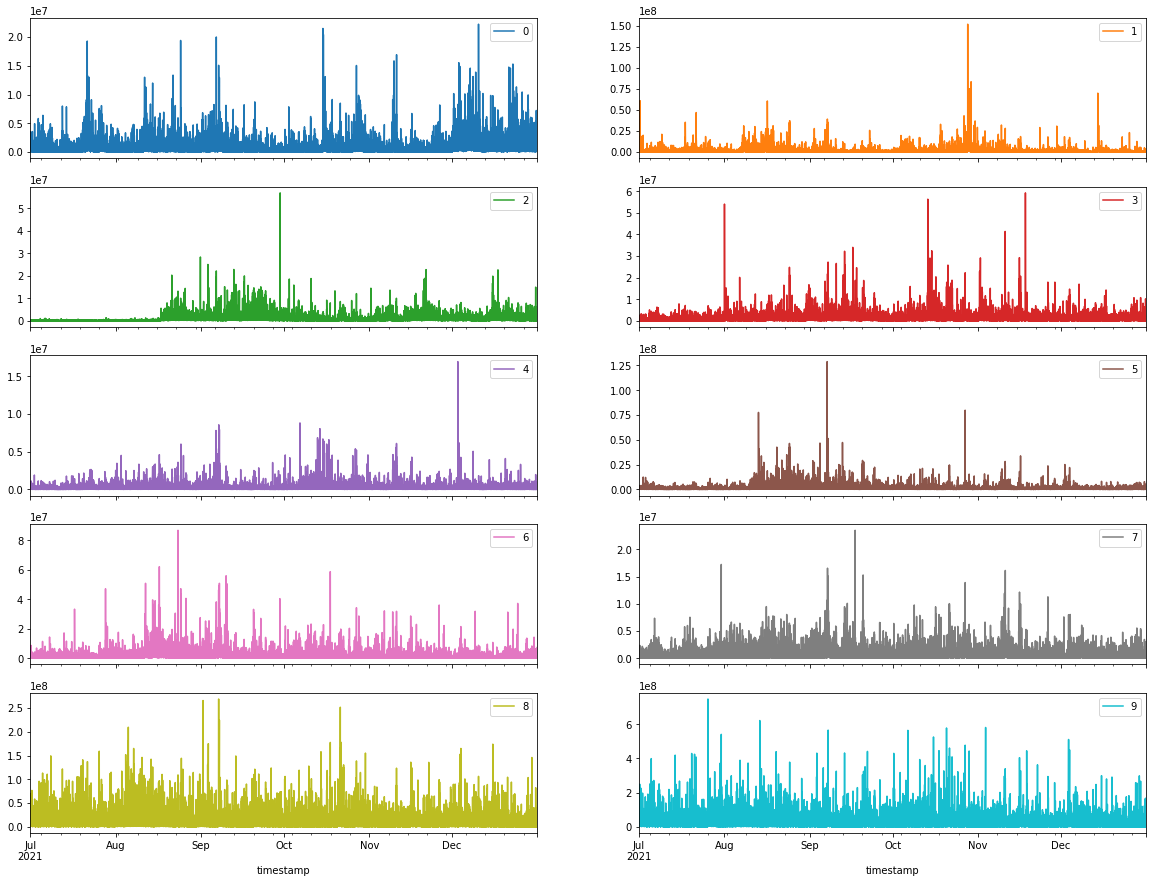

In [6]:
# Check the log-prices of the 10 assets

log_pr.plot(figsize=(12, 8))

# Check the volumes of the 10 assets

fig, axes = plt.subplots(5, 2, sharex=True, figsize=(20, 15))
volu.plot(subplots=True, ax=axes)

### TYWW starts here, 

In [8]:
log_pr_ind_np = np.zeros((10, log_pr.shape[0] // 1440 - 1, 1440))
volume_ind_np = np.zeros((10, log_pr.shape[0] // 1440 - 1, 1440))
for i in range(10):
    log_pr_ind_np[i] = np.delete(
        log_pr[i].to_numpy().reshape(log_pr.shape[0] // 1440, 1440), -1, 0)
    volume_ind_np[i] = np.delete(
        volu[i].to_numpy().reshape(volu.shape[0] // 1440, 1440), -1, 0)

log_pr_ind_np = np.moveaxis(log_pr_ind_np, 0, 1) # (num samples, features, 10)
volume_ind_np = np.moveaxis(volume_ind_np, 0, 1)

log_return_np = (log_pr.shift(-30) - log_pr).iloc[1440:-30:1440].to_numpy()  # (num samples, 10)

In [9]:
X_0 = np.zeros((1440,2,183))
X_0[:,0,:] = log_pr_ind_np[:,0,:].T
X_0[:,1,:] = volume_ind_np[:,0,:].T
train_x_0 = X_0[:,:,:-1]
train_y_0 = X_0[:30,:,1:]

In [10]:
import os
import random
from string import ascii_letters
import torch
from torch import nn
import torch.nn.functional as F

In [11]:
train_x_0 = torch.tensor(train_x_0)
train_y_0 = torch.tensor(train_y_0)

In [25]:
log_pr.to_numpy()[:-1,0].shape

(264959,)

In [39]:
train_X = np.zeros((264959,1,2))
train_Y = np.zeros((264959,1,2))

train_X[:,0,0] = log_pr.to_numpy()[:-1,0]
train_Y[:,0,0] = log_pr.to_numpy()[1:,0]

train_X[:,0,1] = volu.to_numpy()[:-1,0]
train_Y[:,0,1] = volu.to_numpy()[1:,0]


In [47]:
X_train_tensors_final = torch.from_numpy(train_X).float()
Y_train_tensors_final = torch.from_numpy(train_Y).float()

In [66]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer
        self.fc_2 = nn.Linear(128, num_classes) #fully connected last layer
        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
#         print(h_0)
#         print(c_0)
#         print(x)
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out1 = self.fc(out) #Final Output
        out2 = self.fc_2(out)
        return torch.cat((out1, out2), dim=1)

In [ ]:
from torch.autograd import Variable 
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 2 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

batch_size = 1024*16
start = 0
for epoch in range(num_epochs):
    while start + batch_size < len(X_train_tensors_final):
        X_train_tensor_batch = X_train_tensors_final[start:start + batch_size, :]
        Y_rain_tensor_batch = Y_train_tensors_final[start:start + batch_size, :]
        outputs = lstm1.forward(X_train_tensor_batch) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0

      # obtain the loss function
        loss = criterion(outputs, Y_rain_tensor_batch)
        loss.backward() #calculates the loss of the loss function

        optimizer.step() #improve from loss, i.e backprop
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.detach().item())) 

C:\Users\DELL\Anaconda3\envs\neocis\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([16384, 1, 2])) that is different to the input size (torch.Size([16384, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, loss: 87732420608.00000
Epoch: 0, loss: 87732420608.00000
Epoch: 0, loss: 87732404224.00000
Epoch: 0, loss: 87732396032.00000
Epoch: 0, loss: 87732396032.00000
Epoch: 0, loss: 87732387840.00000
Epoch: 0, loss: 87732387840.00000
Epoch: 0, loss: 87732387840.00000
Epoch: 0, loss: 87732379648.00000
Epoch: 0, loss: 87732371456.00000
Epoch: 0, loss: 87732363264.00000
Epoch: 0, loss: 87732363264.00000
Epoch: 0, loss: 87732363264.00000
Epoch: 0, loss: 87732346880.00000
Epoch: 0, loss: 87732346880.00000
Epoch: 0, loss: 87732338688.00000
Epoch: 0, loss: 87732330496.00000
Epoch: 0, loss: 87732322304.00000
Epoch: 0, loss: 87732314112.00000
Epoch: 0, loss: 87732314112.00000
Epoch: 0, loss: 87732314112.00000
Epoch: 0, loss: 87732305920.00000
Epoch: 0, loss: 87732305920.00000
Epoch: 0, loss: 87732305920.00000
Epoch: 0, loss: 87732297728.00000
Epoch: 0, loss: 87732289536.00000
Epoch: 0, loss: 87732281344.00000
Epoch: 0, loss: 87732264960.00000
Epoch: 0, loss: 87732264960.00000
Epoch: 0, loss

Epoch: 0, loss: 87729684480.00000
Epoch: 0, loss: 87729659904.00000
Epoch: 0, loss: 87729651712.00000
Epoch: 0, loss: 87729635328.00000
Epoch: 0, loss: 87729610752.00000
Epoch: 0, loss: 87729594368.00000
Epoch: 0, loss: 87729586176.00000
Epoch: 0, loss: 87729553408.00000
Epoch: 0, loss: 87729537024.00000
Epoch: 0, loss: 87729512448.00000
Epoch: 0, loss: 87729496064.00000
Epoch: 0, loss: 87729471488.00000
Epoch: 0, loss: 87729446912.00000
Epoch: 0, loss: 87729422336.00000
Epoch: 0, loss: 87729397760.00000
Epoch: 0, loss: 87729373184.00000
Epoch: 0, loss: 87729364992.00000
Epoch: 0, loss: 87729348608.00000
Epoch: 0, loss: 87729315840.00000
Epoch: 0, loss: 87729299456.00000
Epoch: 0, loss: 87729283072.00000
Epoch: 0, loss: 87729258496.00000
Epoch: 0, loss: 87729250304.00000
Epoch: 0, loss: 87729225728.00000
Epoch: 0, loss: 87729201152.00000
Epoch: 0, loss: 87729176576.00000
Epoch: 0, loss: 87729152000.00000
Epoch: 0, loss: 87729135616.00000
Epoch: 0, loss: 87729111040.00000
Epoch: 0, loss

Epoch: 0, loss: 87722524672.00000
Epoch: 0, loss: 87722491904.00000
Epoch: 0, loss: 87722442752.00000
Epoch: 0, loss: 87722409984.00000
Epoch: 0, loss: 87722352640.00000
Epoch: 0, loss: 87722328064.00000
Epoch: 0, loss: 87722287104.00000
Epoch: 0, loss: 87722246144.00000
Epoch: 0, loss: 87722213376.00000
Epoch: 0, loss: 87722180608.00000
Epoch: 0, loss: 87722131456.00000
Epoch: 0, loss: 87722082304.00000
Epoch: 0, loss: 87722041344.00000
Epoch: 0, loss: 87722000384.00000
Epoch: 0, loss: 87721984000.00000
Epoch: 0, loss: 87721943040.00000
Epoch: 0, loss: 87721885696.00000
Epoch: 0, loss: 87721828352.00000
Epoch: 0, loss: 87721803776.00000
Epoch: 0, loss: 87721771008.00000
Epoch: 0, loss: 87721730048.00000
Epoch: 0, loss: 87721680896.00000
Epoch: 0, loss: 87721631744.00000
Epoch: 0, loss: 87721598976.00000
Epoch: 0, loss: 87721541632.00000
Epoch: 0, loss: 87721517056.00000
Epoch: 0, loss: 87721459712.00000
Epoch: 0, loss: 87721435136.00000
Epoch: 0, loss: 87721385984.00000
Epoch: 0, loss

Epoch: 0, loss: 87710957568.00000
Epoch: 0, loss: 87710908416.00000
Epoch: 0, loss: 87710851072.00000
Epoch: 0, loss: 87710793728.00000
Epoch: 0, loss: 87710744576.00000
Epoch: 0, loss: 87710679040.00000
Epoch: 0, loss: 87710621696.00000
Epoch: 0, loss: 87710572544.00000
Epoch: 0, loss: 87710507008.00000
Epoch: 0, loss: 87710449664.00000
Epoch: 0, loss: 87710384128.00000
Epoch: 0, loss: 87710343168.00000
Epoch: 0, loss: 87710277632.00000
Epoch: 0, loss: 87710220288.00000
Epoch: 0, loss: 87710154752.00000
Epoch: 0, loss: 87710089216.00000
Epoch: 0, loss: 87710040064.00000
Epoch: 0, loss: 87709990912.00000
Epoch: 0, loss: 87709925376.00000
Epoch: 0, loss: 87709868032.00000
Epoch: 0, loss: 87709810688.00000
Epoch: 0, loss: 87709745152.00000
Epoch: 0, loss: 87709687808.00000
Epoch: 0, loss: 87709630464.00000
Epoch: 0, loss: 87709573120.00000
Epoch: 0, loss: 87709515776.00000
Epoch: 0, loss: 87709458432.00000
Epoch: 0, loss: 87709401088.00000
Epoch: 0, loss: 87709360128.00000
Epoch: 0, loss

Epoch: 0, loss: 87695368192.00000
Epoch: 0, loss: 87695294464.00000
Epoch: 0, loss: 87695228928.00000
Epoch: 0, loss: 87695155200.00000
Epoch: 0, loss: 87695089664.00000
Epoch: 0, loss: 87695007744.00000
Epoch: 0, loss: 87694942208.00000
Epoch: 0, loss: 87694852096.00000
Epoch: 0, loss: 87694778368.00000
Epoch: 0, loss: 87694721024.00000
Epoch: 0, loss: 87694639104.00000
Epoch: 0, loss: 87694565376.00000
Epoch: 0, loss: 87694491648.00000
Epoch: 0, loss: 87694409728.00000
Epoch: 0, loss: 87694336000.00000
Epoch: 0, loss: 87694254080.00000
Epoch: 0, loss: 87694188544.00000
Epoch: 0, loss: 87694131200.00000
Epoch: 0, loss: 87694065664.00000
Epoch: 0, loss: 87693991936.00000
Epoch: 0, loss: 87693926400.00000
Epoch: 0, loss: 87693844480.00000
Epoch: 0, loss: 87693754368.00000
Epoch: 0, loss: 87693688832.00000
Epoch: 0, loss: 87693606912.00000
Epoch: 0, loss: 87693524992.00000
Epoch: 0, loss: 87693459456.00000
Epoch: 0, loss: 87693377536.00000
Epoch: 0, loss: 87693303808.00000
Epoch: 0, loss

Epoch: 0, loss: 87676092416.00000
Epoch: 0, loss: 87676002304.00000
Epoch: 0, loss: 87675904000.00000
Epoch: 0, loss: 87675805696.00000
Epoch: 0, loss: 87675731968.00000
Epoch: 0, loss: 87675641856.00000
Epoch: 0, loss: 87675551744.00000
Epoch: 0, loss: 87675469824.00000
Epoch: 0, loss: 87675355136.00000
Epoch: 0, loss: 87675281408.00000
Epoch: 0, loss: 87675199488.00000
Epoch: 0, loss: 87675109376.00000
Epoch: 0, loss: 87675019264.00000
Epoch: 0, loss: 87674920960.00000
Epoch: 0, loss: 87674847232.00000
Epoch: 0, loss: 87674748928.00000
Epoch: 0, loss: 87674667008.00000
Epoch: 0, loss: 87674585088.00000
Epoch: 0, loss: 87674503168.00000
Epoch: 0, loss: 87674421248.00000
Epoch: 0, loss: 87674322944.00000
Epoch: 0, loss: 87674241024.00000
Epoch: 0, loss: 87674134528.00000
Epoch: 0, loss: 87674060800.00000
Epoch: 0, loss: 87673962496.00000
Epoch: 0, loss: 87673864192.00000
Epoch: 0, loss: 87673765888.00000
Epoch: 0, loss: 87673692160.00000
Epoch: 0, loss: 87673610240.00000
Epoch: 0, loss

Epoch: 0, loss: 87653359616.00000
Epoch: 0, loss: 87653261312.00000
Epoch: 0, loss: 87653154816.00000
Epoch: 0, loss: 87653056512.00000
Epoch: 0, loss: 87652941824.00000
Epoch: 0, loss: 87652843520.00000
Epoch: 0, loss: 87652761600.00000
Epoch: 0, loss: 87652655104.00000
Epoch: 0, loss: 87652548608.00000
Epoch: 0, loss: 87652425728.00000
Epoch: 0, loss: 87652327424.00000
Epoch: 0, loss: 87652229120.00000
Epoch: 0, loss: 87652139008.00000
Epoch: 0, loss: 87652048896.00000
Epoch: 0, loss: 87651942400.00000
Epoch: 0, loss: 87651852288.00000
Epoch: 0, loss: 87651729408.00000
Epoch: 0, loss: 87651631104.00000
Epoch: 0, loss: 87651532800.00000
Epoch: 0, loss: 87651434496.00000
Epoch: 0, loss: 87651319808.00000
Epoch: 0, loss: 87651221504.00000
Epoch: 0, loss: 87651115008.00000
Epoch: 0, loss: 87651016704.00000
Epoch: 0, loss: 87650910208.00000
Epoch: 0, loss: 87650811904.00000
Epoch: 0, loss: 87650713600.00000
Epoch: 0, loss: 87650598912.00000
Epoch: 0, loss: 87650500608.00000
Epoch: 0, loss

Epoch: 0, loss: 87627431936.00000
Epoch: 0, loss: 87627333632.00000
Epoch: 0, loss: 87627227136.00000
Epoch: 0, loss: 87627104256.00000
Epoch: 0, loss: 87626981376.00000
Epoch: 0, loss: 87626858496.00000
Epoch: 0, loss: 87626760192.00000
Epoch: 0, loss: 87626645504.00000
Epoch: 0, loss: 87626522624.00000
Epoch: 0, loss: 87626416128.00000
Epoch: 0, loss: 87626301440.00000
Epoch: 0, loss: 87626203136.00000
Epoch: 0, loss: 87626088448.00000
Epoch: 0, loss: 87625965568.00000
Epoch: 0, loss: 87625850880.00000
Epoch: 0, loss: 87625728000.00000
Epoch: 0, loss: 87625621504.00000
Epoch: 0, loss: 87625506816.00000
Epoch: 0, loss: 87625383936.00000
Epoch: 0, loss: 87625261056.00000
Epoch: 0, loss: 87625146368.00000
Epoch: 0, loss: 87625039872.00000
Epoch: 0, loss: 87624933376.00000
Epoch: 0, loss: 87624826880.00000
Epoch: 0, loss: 87624687616.00000
Epoch: 0, loss: 87624572928.00000
Epoch: 0, loss: 87624474624.00000
Epoch: 0, loss: 87624343552.00000
Epoch: 0, loss: 87624220672.00000
Epoch: 0, loss

Epoch: 0, loss: 87598546944.00000
Epoch: 0, loss: 87598415872.00000
Epoch: 0, loss: 87598301184.00000
Epoch: 0, loss: 87598161920.00000
Epoch: 0, loss: 87598039040.00000
Epoch: 0, loss: 87597899776.00000
Epoch: 0, loss: 87597776896.00000
Epoch: 0, loss: 87597678592.00000
Epoch: 0, loss: 87597531136.00000
Epoch: 0, loss: 87597416448.00000
Epoch: 0, loss: 87597285376.00000
Epoch: 0, loss: 87597154304.00000
Epoch: 0, loss: 87597015040.00000
Epoch: 0, loss: 87596892160.00000
Epoch: 0, loss: 87596769280.00000
Epoch: 0, loss: 87596654592.00000
Epoch: 0, loss: 87596539904.00000
Epoch: 0, loss: 87596408832.00000
Epoch: 0, loss: 87596269568.00000
Epoch: 0, loss: 87596146688.00000
Epoch: 0, loss: 87596015616.00000
Epoch: 0, loss: 87595892736.00000
Epoch: 0, loss: 87595753472.00000
Epoch: 0, loss: 87595630592.00000
Epoch: 0, loss: 87595499520.00000
Epoch: 0, loss: 87595384832.00000
Epoch: 0, loss: 87595253760.00000
Epoch: 0, loss: 87595139072.00000
Epoch: 0, loss: 87595008000.00000
Epoch: 0, loss

Epoch: 0, loss: 87566827520.00000
Epoch: 0, loss: 87566688256.00000
Epoch: 0, loss: 87566540800.00000
Epoch: 0, loss: 87566401536.00000
Epoch: 0, loss: 87566262272.00000
Epoch: 0, loss: 87566123008.00000
Epoch: 0, loss: 87566000128.00000
Epoch: 0, loss: 87565852672.00000
Epoch: 0, loss: 87565721600.00000
Epoch: 0, loss: 87565590528.00000
Epoch: 0, loss: 87565451264.00000
Epoch: 0, loss: 87565295616.00000
Epoch: 0, loss: 87565156352.00000
Epoch: 0, loss: 87565025280.00000
Epoch: 0, loss: 87564902400.00000
Epoch: 0, loss: 87564771328.00000
Epoch: 0, loss: 87564615680.00000
Epoch: 0, loss: 87564476416.00000
Epoch: 0, loss: 87564353536.00000
Epoch: 0, loss: 87564197888.00000
Epoch: 0, loss: 87564066816.00000
Epoch: 0, loss: 87563919360.00000
Epoch: 0, loss: 87563796480.00000
Epoch: 0, loss: 87563632640.00000
Epoch: 0, loss: 87563501568.00000
Epoch: 0, loss: 87563378688.00000
Epoch: 0, loss: 87563223040.00000
Epoch: 0, loss: 87563091968.00000
Epoch: 0, loss: 87562960896.00000
Epoch: 0, loss

Epoch: 0, loss: 87532421120.00000
Epoch: 0, loss: 87532273664.00000
Epoch: 0, loss: 87532142592.00000
Epoch: 0, loss: 87531978752.00000
Epoch: 0, loss: 87531839488.00000
Epoch: 0, loss: 87531667456.00000
Epoch: 0, loss: 87531520000.00000
Epoch: 0, loss: 87531388928.00000
Epoch: 0, loss: 87531241472.00000
Epoch: 0, loss: 87531077632.00000
Epoch: 0, loss: 87530921984.00000
Epoch: 0, loss: 87530790912.00000
Epoch: 0, loss: 87530659840.00000
Epoch: 0, loss: 87530504192.00000
Epoch: 0, loss: 87530340352.00000
Epoch: 0, loss: 87530201088.00000
Epoch: 0, loss: 87530029056.00000
Epoch: 0, loss: 87529906176.00000
Epoch: 0, loss: 87529742336.00000
Epoch: 0, loss: 87529611264.00000
Epoch: 0, loss: 87529447424.00000
Epoch: 0, loss: 87529308160.00000
Epoch: 0, loss: 87529144320.00000
Epoch: 0, loss: 87528980480.00000
Epoch: 0, loss: 87528841216.00000
Epoch: 0, loss: 87528710144.00000
Epoch: 0, loss: 87528562688.00000
Epoch: 0, loss: 87528415232.00000
Epoch: 0, loss: 87528251392.00000
Epoch: 0, loss

Epoch: 0, loss: 87495475200.00000
Epoch: 0, loss: 87495327744.00000
Epoch: 0, loss: 87495147520.00000
Epoch: 0, loss: 87495000064.00000
Epoch: 0, loss: 87494836224.00000
Epoch: 0, loss: 87494672384.00000
Epoch: 0, loss: 87494524928.00000
Epoch: 0, loss: 87494352896.00000
Epoch: 0, loss: 87494213632.00000
Epoch: 0, loss: 87494049792.00000
Epoch: 0, loss: 87493885952.00000
Epoch: 0, loss: 87493730304.00000
Epoch: 0, loss: 87493558272.00000
Epoch: 0, loss: 87493410816.00000
Epoch: 0, loss: 87493255168.00000
Epoch: 0, loss: 87493091328.00000
Epoch: 0, loss: 87492927488.00000
Epoch: 0, loss: 87492780032.00000
Epoch: 0, loss: 87492599808.00000
Epoch: 0, loss: 87492460544.00000
Epoch: 0, loss: 87492280320.00000
Epoch: 0, loss: 87492141056.00000
Epoch: 0, loss: 87491985408.00000
Epoch: 0, loss: 87491821568.00000
Epoch: 0, loss: 87491649536.00000
Epoch: 0, loss: 87491493888.00000
Epoch: 0, loss: 87491330048.00000
Epoch: 0, loss: 87491182592.00000
Epoch: 0, loss: 87491010560.00000
Epoch: 0, loss

Epoch: 0, loss: 87456079872.00000
Epoch: 0, loss: 87455899648.00000
Epoch: 0, loss: 87455727616.00000
Epoch: 0, loss: 87455563776.00000
Epoch: 0, loss: 87455391744.00000
Epoch: 0, loss: 87455236096.00000
Epoch: 0, loss: 87455064064.00000
Epoch: 0, loss: 87454883840.00000
Epoch: 0, loss: 87454736384.00000
Epoch: 0, loss: 87454556160.00000
Epoch: 0, loss: 87454384128.00000
Epoch: 0, loss: 87454203904.00000
Epoch: 0, loss: 87454056448.00000
Epoch: 0, loss: 87453859840.00000
Epoch: 0, loss: 87453720576.00000
Epoch: 0, loss: 87453556736.00000
Epoch: 0, loss: 87453376512.00000
Epoch: 0, loss: 87453196288.00000
Epoch: 0, loss: 87453032448.00000
Epoch: 0, loss: 87452860416.00000
Epoch: 0, loss: 87452688384.00000
Epoch: 0, loss: 87452524544.00000
Epoch: 0, loss: 87452352512.00000
Epoch: 0, loss: 87452188672.00000
Epoch: 0, loss: 87452024832.00000
Epoch: 0, loss: 87451844608.00000
Epoch: 0, loss: 87451672576.00000
Epoch: 0, loss: 87451516928.00000
Epoch: 0, loss: 87451353088.00000
Epoch: 0, loss

Epoch: 0, loss: 87414325248.00000
Epoch: 0, loss: 87414136832.00000
Epoch: 0, loss: 87413956608.00000
Epoch: 0, loss: 87413784576.00000
Epoch: 0, loss: 87413612544.00000
Epoch: 0, loss: 87413432320.00000
Epoch: 0, loss: 87413252096.00000
Epoch: 0, loss: 87413063680.00000
Epoch: 0, loss: 87412891648.00000
Epoch: 0, loss: 87412703232.00000
Epoch: 0, loss: 87412539392.00000
Epoch: 0, loss: 87412359168.00000
Epoch: 0, loss: 87412187136.00000
Epoch: 0, loss: 87412006912.00000
Epoch: 0, loss: 87411826688.00000
Epoch: 0, loss: 87411638272.00000
Epoch: 0, loss: 87411449856.00000
Epoch: 0, loss: 87411277824.00000
Epoch: 0, loss: 87411122176.00000
Epoch: 0, loss: 87410917376.00000
Epoch: 0, loss: 87410761728.00000
Epoch: 0, loss: 87410581504.00000
Epoch: 0, loss: 87410401280.00000
Epoch: 0, loss: 87410196480.00000
Epoch: 0, loss: 87410024448.00000
Epoch: 0, loss: 87409852416.00000
Epoch: 0, loss: 87409688576.00000
Epoch: 0, loss: 87409500160.00000
Epoch: 0, loss: 87409336320.00000
Epoch: 0, loss

Epoch: 0, loss: 87370285056.00000
Epoch: 0, loss: 87370080256.00000
Epoch: 0, loss: 87369908224.00000
Epoch: 0, loss: 87369719808.00000
Epoch: 0, loss: 87369539584.00000
Epoch: 0, loss: 87369342976.00000
Epoch: 0, loss: 87369154560.00000
Epoch: 0, loss: 87368966144.00000
Epoch: 0, loss: 87368785920.00000
Epoch: 0, loss: 87368605696.00000
Epoch: 0, loss: 87368433664.00000
Epoch: 0, loss: 87368220672.00000
Epoch: 0, loss: 87368015872.00000
Epoch: 0, loss: 87367827456.00000
Epoch: 0, loss: 87367647232.00000
Epoch: 0, loss: 87367467008.00000
Epoch: 0, loss: 87367286784.00000
Epoch: 0, loss: 87367090176.00000
Epoch: 0, loss: 87366909952.00000
Epoch: 0, loss: 87366721536.00000
Epoch: 0, loss: 87366516736.00000
Epoch: 0, loss: 87366328320.00000
Epoch: 0, loss: 87366131712.00000
Epoch: 0, loss: 87365959680.00000
Epoch: 0, loss: 87365779456.00000
Epoch: 0, loss: 87365582848.00000
Epoch: 0, loss: 87365386240.00000
Epoch: 0, loss: 87365222400.00000
Epoch: 0, loss: 87365001216.00000
Epoch: 0, loss

Epoch: 0, loss: 87324041216.00000
Epoch: 0, loss: 87323820032.00000
Epoch: 0, loss: 87323615232.00000
Epoch: 0, loss: 87323426816.00000
Epoch: 0, loss: 87323246592.00000
Epoch: 0, loss: 87323041792.00000
Epoch: 0, loss: 87322853376.00000
Epoch: 0, loss: 87322632192.00000
Epoch: 0, loss: 87322451968.00000
Epoch: 0, loss: 87322263552.00000
Epoch: 0, loss: 87322058752.00000
Epoch: 0, loss: 87321870336.00000
Epoch: 0, loss: 87321673728.00000
Epoch: 0, loss: 87321468928.00000
Epoch: 0, loss: 87321264128.00000
Epoch: 0, loss: 87321067520.00000
Epoch: 0, loss: 87320895488.00000
Epoch: 0, loss: 87320674304.00000
Epoch: 0, loss: 87320477696.00000
Epoch: 0, loss: 87320289280.00000
Epoch: 0, loss: 87320084480.00000
Epoch: 0, loss: 87319887872.00000
Epoch: 0, loss: 87319699456.00000
Epoch: 0, loss: 87319502848.00000
Epoch: 0, loss: 87319281664.00000
Epoch: 0, loss: 87319101440.00000
Epoch: 0, loss: 87318921216.00000
Epoch: 0, loss: 87318708224.00000
Epoch: 0, loss: 87318511616.00000
Epoch: 0, loss

Epoch: 0, loss: 87275601920.00000
Epoch: 0, loss: 87275405312.00000
Epoch: 0, loss: 87275192320.00000
Epoch: 0, loss: 87274979328.00000
Epoch: 0, loss: 87274799104.00000
Epoch: 0, loss: 87274569728.00000
Epoch: 0, loss: 87274381312.00000
Epoch: 0, loss: 87274176512.00000
Epoch: 0, loss: 87273955328.00000
Epoch: 0, loss: 87273750528.00000
Epoch: 0, loss: 87273537536.00000
Epoch: 0, loss: 87273349120.00000
Epoch: 0, loss: 87273152512.00000
Epoch: 0, loss: 87272939520.00000
Epoch: 0, loss: 87272718336.00000
Epoch: 0, loss: 87272529920.00000
Epoch: 0, loss: 87272316928.00000
Epoch: 0, loss: 87272120320.00000
Epoch: 0, loss: 87271899136.00000
Epoch: 0, loss: 87271694336.00000
Epoch: 0, loss: 87271481344.00000
Epoch: 0, loss: 87271276544.00000
Epoch: 0, loss: 87271079936.00000
Epoch: 0, loss: 87270875136.00000
Epoch: 0, loss: 87270670336.00000
Epoch: 0, loss: 87270449152.00000
Epoch: 0, loss: 87270236160.00000
Epoch: 0, loss: 87270055936.00000
Epoch: 0, loss: 87269842944.00000
Epoch: 0, loss

Epoch: 0, loss: 87225090048.00000
Epoch: 0, loss: 87224860672.00000
Epoch: 0, loss: 87224647680.00000
Epoch: 0, loss: 87224418304.00000
Epoch: 0, loss: 87224205312.00000
Epoch: 0, loss: 87223992320.00000
Epoch: 0, loss: 87223779328.00000
Epoch: 0, loss: 87223566336.00000
Epoch: 0, loss: 87223353344.00000
Epoch: 0, loss: 87223148544.00000
Epoch: 0, loss: 87222943744.00000
Epoch: 0, loss: 87222689792.00000
Epoch: 0, loss: 87222501376.00000
Epoch: 0, loss: 87222280192.00000
Epoch: 0, loss: 87222067200.00000
Epoch: 0, loss: 87221862400.00000
Epoch: 0, loss: 87221633024.00000
Epoch: 0, loss: 87221428224.00000
Epoch: 0, loss: 87221207040.00000
Epoch: 0, loss: 87220985856.00000
Epoch: 0, loss: 87220764672.00000
Epoch: 0, loss: 87220568064.00000
Epoch: 0, loss: 87220363264.00000
Epoch: 0, loss: 87220150272.00000
Epoch: 0, loss: 87219920896.00000
Epoch: 0, loss: 87219724288.00000
Epoch: 0, loss: 87219486720.00000
Epoch: 0, loss: 87219273728.00000
Epoch: 0, loss: 87219060736.00000
Epoch: 0, loss

Epoch: 0, loss: 87172456448.00000
Epoch: 0, loss: 87172218880.00000
Epoch: 0, loss: 87172022272.00000
Epoch: 0, loss: 87171792896.00000
Epoch: 0, loss: 87171563520.00000
Epoch: 0, loss: 87171334144.00000
Epoch: 0, loss: 87171112960.00000
Epoch: 0, loss: 87170908160.00000
Epoch: 0, loss: 87170678784.00000
Epoch: 0, loss: 87170449408.00000
Epoch: 0, loss: 87170211840.00000
Epoch: 0, loss: 87170007040.00000
Epoch: 0, loss: 87169777664.00000
Epoch: 0, loss: 87169548288.00000
Epoch: 0, loss: 87169318912.00000
Epoch: 0, loss: 87169122304.00000
Epoch: 0, loss: 87168901120.00000
Epoch: 0, loss: 87168647168.00000
Epoch: 0, loss: 87168450560.00000
Epoch: 0, loss: 87168229376.00000
Epoch: 0, loss: 87168000000.00000
Epoch: 0, loss: 87167770624.00000
Epoch: 0, loss: 87167541248.00000
Epoch: 0, loss: 87167336448.00000
Epoch: 0, loss: 87167107072.00000
Epoch: 0, loss: 87166877696.00000
Epoch: 0, loss: 87166648320.00000
Epoch: 0, loss: 87166418944.00000
Epoch: 0, loss: 87166222336.00000
Epoch: 0, loss

Epoch: 0, loss: 87117799424.00000
Epoch: 0, loss: 87117570048.00000
Epoch: 0, loss: 87117348864.00000
Epoch: 0, loss: 87117119488.00000
Epoch: 0, loss: 87116881920.00000
Epoch: 0, loss: 87116652544.00000
Epoch: 0, loss: 87116414976.00000
Epoch: 0, loss: 87116169216.00000
Epoch: 0, loss: 87115948032.00000
Epoch: 0, loss: 87115726848.00000
Epoch: 0, loss: 87115513856.00000
Epoch: 0, loss: 87115284480.00000
Epoch: 0, loss: 87115005952.00000
Epoch: 0, loss: 87114801152.00000
Epoch: 0, loss: 87114571776.00000
Epoch: 0, loss: 87114326016.00000
Epoch: 0, loss: 87114096640.00000
Epoch: 0, loss: 87113875456.00000
Epoch: 0, loss: 87113637888.00000
Epoch: 0, loss: 87113416704.00000
Epoch: 0, loss: 87113187328.00000
Epoch: 0, loss: 87112933376.00000
Epoch: 0, loss: 87112712192.00000
Epoch: 0, loss: 87112482816.00000
Epoch: 0, loss: 87112245248.00000
Epoch: 0, loss: 87112015872.00000
Epoch: 0, loss: 87111794688.00000
Epoch: 0, loss: 87111573504.00000
Epoch: 0, loss: 87111327744.00000
Epoch: 0, loss

Epoch: 0, loss: 87061151744.00000
Epoch: 0, loss: 87060889600.00000
Epoch: 0, loss: 87060652032.00000
Epoch: 0, loss: 87060414464.00000
Epoch: 0, loss: 87060209664.00000
Epoch: 0, loss: 87059939328.00000
Epoch: 0, loss: 87059701760.00000
Epoch: 0, loss: 87059464192.00000
Epoch: 0, loss: 87059218432.00000
Epoch: 0, loss: 87058980864.00000
Epoch: 0, loss: 87058743296.00000
Epoch: 0, loss: 87058505728.00000
Epoch: 0, loss: 87058259968.00000
Epoch: 0, loss: 87058030592.00000
Epoch: 0, loss: 87057784832.00000
Epoch: 0, loss: 87057539072.00000
Epoch: 0, loss: 87057317888.00000
Epoch: 0, loss: 87057063936.00000
Epoch: 0, loss: 87056834560.00000
Epoch: 0, loss: 87056588800.00000
Epoch: 0, loss: 87056351232.00000
Epoch: 0, loss: 87056113664.00000
Epoch: 0, loss: 87055859712.00000
Epoch: 0, loss: 87055622144.00000
Epoch: 0, loss: 87055392768.00000
Epoch: 0, loss: 87055130624.00000
Epoch: 0, loss: 87054901248.00000
Epoch: 0, loss: 87054663680.00000
Epoch: 0, loss: 87054434304.00000
Epoch: 0, loss

Epoch: 0, loss: 87002488832.00000
Epoch: 0, loss: 87002259456.00000
Epoch: 0, loss: 87002013696.00000
Epoch: 0, loss: 87001743360.00000
Epoch: 0, loss: 87001505792.00000
Epoch: 0, loss: 87001268224.00000
Epoch: 0, loss: 87001014272.00000
Epoch: 0, loss: 87000776704.00000
Epoch: 0, loss: 87000522752.00000
Epoch: 0, loss: 87000260608.00000
Epoch: 0, loss: 87000031232.00000
Epoch: 0, loss: 86999769088.00000
Epoch: 0, loss: 86999539712.00000
Epoch: 0, loss: 86999261184.00000
Epoch: 0, loss: 86999023616.00000
Epoch: 0, loss: 86998786048.00000
Epoch: 0, loss: 86998532096.00000
Epoch: 0, loss: 86998294528.00000
Epoch: 0, loss: 86998032384.00000
Epoch: 0, loss: 86997803008.00000
Epoch: 0, loss: 86997532672.00000
Epoch: 0, loss: 86997286912.00000
Epoch: 0, loss: 86997041152.00000
Epoch: 0, loss: 86996811776.00000
Epoch: 0, loss: 86996549632.00000
Epoch: 0, loss: 86996303872.00000
Epoch: 0, loss: 86996058112.00000
Epoch: 0, loss: 86995804160.00000
Epoch: 0, loss: 86995550208.00000
Epoch: 0, loss

Epoch: 0, loss: 86941884416.00000
Epoch: 0, loss: 86941622272.00000
Epoch: 0, loss: 86941392896.00000
Epoch: 0, loss: 86941138944.00000
Epoch: 0, loss: 86940868608.00000
Epoch: 0, loss: 86940614656.00000
Epoch: 0, loss: 86940352512.00000
Epoch: 0, loss: 86940098560.00000
Epoch: 0, loss: 86939852800.00000
Epoch: 0, loss: 86939582464.00000
Epoch: 0, loss: 86939344896.00000
Epoch: 0, loss: 86939082752.00000
Epoch: 0, loss: 86938828800.00000
Epoch: 0, loss: 86938583040.00000
Epoch: 0, loss: 86938312704.00000
Epoch: 0, loss: 86938058752.00000
Epoch: 0, loss: 86937796608.00000
Epoch: 0, loss: 86937534464.00000
Epoch: 0, loss: 86937288704.00000
Epoch: 0, loss: 86937034752.00000
Epoch: 0, loss: 86936772608.00000
Epoch: 0, loss: 86936526848.00000
Epoch: 0, loss: 86936256512.00000
Epoch: 0, loss: 86935986176.00000
Epoch: 0, loss: 86935764992.00000
Epoch: 0, loss: 86935486464.00000
Epoch: 0, loss: 86935240704.00000
Epoch: 0, loss: 86934978560.00000
Epoch: 0, loss: 86934732800.00000
Epoch: 0, loss

Epoch: 0, loss: 86879354880.00000
Epoch: 0, loss: 86879092736.00000
Epoch: 0, loss: 86878838784.00000
Epoch: 0, loss: 86878584832.00000
Epoch: 0, loss: 86878298112.00000
Epoch: 0, loss: 86878019584.00000
Epoch: 0, loss: 86877765632.00000
Epoch: 0, loss: 86877503488.00000
Epoch: 0, loss: 86877249536.00000
Epoch: 0, loss: 86876987392.00000
Epoch: 0, loss: 86876708864.00000
Epoch: 0, loss: 86876463104.00000
Epoch: 0, loss: 86876192768.00000
Epoch: 0, loss: 86875922432.00000
Epoch: 0, loss: 86875652096.00000
Epoch: 0, loss: 86875389952.00000
Epoch: 0, loss: 86875127808.00000
Epoch: 0, loss: 86874857472.00000
Epoch: 0, loss: 86874595328.00000
Epoch: 0, loss: 86874341376.00000
Epoch: 0, loss: 86874095616.00000
Epoch: 0, loss: 86873817088.00000
Epoch: 0, loss: 86873546752.00000
Epoch: 0, loss: 86873268224.00000
Epoch: 0, loss: 86873030656.00000
Epoch: 0, loss: 86872735744.00000
Epoch: 0, loss: 86872489984.00000
Epoch: 0, loss: 86872236032.00000
Epoch: 0, loss: 86871973888.00000
Epoch: 0, loss

Epoch: 0, loss: 86814916608.00000
Epoch: 0, loss: 86814621696.00000
Epoch: 0, loss: 86814359552.00000
Epoch: 0, loss: 86814089216.00000
Epoch: 0, loss: 86813810688.00000
Epoch: 0, loss: 86813548544.00000
Epoch: 0, loss: 86813270016.00000
Epoch: 0, loss: 86812991488.00000
Epoch: 0, loss: 86812729344.00000
Epoch: 0, loss: 86812467200.00000
Epoch: 0, loss: 86812180480.00000
Epoch: 0, loss: 86811918336.00000
Epoch: 0, loss: 86811639808.00000
Epoch: 0, loss: 86811369472.00000
Epoch: 0, loss: 86811090944.00000
Epoch: 0, loss: 86810828800.00000
Epoch: 0, loss: 86810550272.00000
Epoch: 0, loss: 86810279936.00000
Epoch: 0, loss: 86810001408.00000
Epoch: 0, loss: 86809722880.00000
Epoch: 0, loss: 86809460736.00000
Epoch: 0, loss: 86809190400.00000
Epoch: 0, loss: 86808920064.00000
Epoch: 0, loss: 86808649728.00000
Epoch: 0, loss: 86808354816.00000
Epoch: 0, loss: 86808109056.00000
Epoch: 0, loss: 86807830528.00000
Epoch: 0, loss: 86807560192.00000
Epoch: 0, loss: 86807298048.00000
Epoch: 0, loss

Epoch: 0, loss: 86748545024.00000
Epoch: 0, loss: 86748274688.00000
Epoch: 0, loss: 86747979776.00000
Epoch: 0, loss: 86747701248.00000
Epoch: 0, loss: 86747414528.00000
Epoch: 0, loss: 86747152384.00000
Epoch: 0, loss: 86746865664.00000
Epoch: 0, loss: 86746578944.00000
Epoch: 0, loss: 86746300416.00000
Epoch: 0, loss: 86746030080.00000
Epoch: 0, loss: 86745743360.00000
Epoch: 0, loss: 86745473024.00000
Epoch: 0, loss: 86745194496.00000
Epoch: 0, loss: 86744907776.00000
Epoch: 0, loss: 86744637440.00000
Epoch: 0, loss: 86744326144.00000
Epoch: 0, loss: 86744064000.00000
Epoch: 0, loss: 86743793664.00000
Epoch: 0, loss: 86743515136.00000
Epoch: 0, loss: 86743228416.00000
Epoch: 0, loss: 86742949888.00000
Epoch: 0, loss: 86742663168.00000
Epoch: 0, loss: 86742401024.00000
Epoch: 0, loss: 86742106112.00000
Epoch: 0, loss: 86741835776.00000
Epoch: 0, loss: 86741557248.00000
Epoch: 0, loss: 86741278720.00000
Epoch: 0, loss: 86740992000.00000
Epoch: 0, loss: 86740705280.00000
Epoch: 0, loss

Epoch: 0, loss: 86680305664.00000
Epoch: 0, loss: 86680010752.00000
Epoch: 0, loss: 86679724032.00000
Epoch: 0, loss: 86679437312.00000
Epoch: 0, loss: 86679158784.00000
Epoch: 0, loss: 86678872064.00000
Epoch: 0, loss: 86678568960.00000
Epoch: 0, loss: 86678290432.00000
Epoch: 0, loss: 86678011904.00000
Epoch: 0, loss: 86677716992.00000
Epoch: 0, loss: 86677438464.00000
Epoch: 0, loss: 86677143552.00000
Epoch: 0, loss: 86676856832.00000
Epoch: 0, loss: 86676561920.00000
Epoch: 0, loss: 86676283392.00000
Epoch: 0, loss: 86675988480.00000
Epoch: 0, loss: 86675709952.00000
Epoch: 0, loss: 86675423232.00000
Epoch: 0, loss: 86675128320.00000
Epoch: 0, loss: 86674825216.00000
Epoch: 0, loss: 86674571264.00000
Epoch: 0, loss: 86674251776.00000
Epoch: 0, loss: 86673989632.00000
Epoch: 0, loss: 86673686528.00000
Epoch: 0, loss: 86673399808.00000
Epoch: 0, loss: 86673129472.00000
Epoch: 0, loss: 86672834560.00000
Epoch: 0, loss: 86672539648.00000
Epoch: 0, loss: 86672244736.00000
Epoch: 0, loss

Epoch: 0, loss: 86610223104.00000
Epoch: 0, loss: 86609879040.00000
Epoch: 0, loss: 86609600512.00000
Epoch: 0, loss: 86609305600.00000
Epoch: 0, loss: 86609010688.00000
Epoch: 0, loss: 86608723968.00000
Epoch: 0, loss: 86608429056.00000
Epoch: 0, loss: 86608142336.00000
Epoch: 0, loss: 86607839232.00000
Epoch: 0, loss: 86607552512.00000
Epoch: 0, loss: 86607249408.00000
Epoch: 0, loss: 86606946304.00000
Epoch: 0, loss: 86606675968.00000
Epoch: 0, loss: 86606364672.00000
Epoch: 0, loss: 86606069760.00000
Epoch: 0, loss: 86605774848.00000
Epoch: 0, loss: 86605471744.00000
Epoch: 0, loss: 86605185024.00000
Epoch: 0, loss: 86604881920.00000
Epoch: 0, loss: 86604611584.00000
Epoch: 0, loss: 86604292096.00000
Epoch: 0, loss: 86603988992.00000
Epoch: 0, loss: 86603702272.00000
Epoch: 0, loss: 86603415552.00000
Epoch: 0, loss: 86603112448.00000
Epoch: 0, loss: 86602825728.00000
Epoch: 0, loss: 86602506240.00000
Epoch: 0, loss: 86602219520.00000
Epoch: 0, loss: 86601949184.00000
Epoch: 0, loss

Epoch: 0, loss: 86538231808.00000
Epoch: 0, loss: 86537928704.00000
Epoch: 0, loss: 86537633792.00000
Epoch: 0, loss: 86537330688.00000
Epoch: 0, loss: 86537027584.00000
Epoch: 0, loss: 86536716288.00000
Epoch: 0, loss: 86536421376.00000
Epoch: 0, loss: 86536118272.00000
Epoch: 0, loss: 86535806976.00000
Epoch: 0, loss: 86535512064.00000
Epoch: 0, loss: 86535225344.00000
Epoch: 0, loss: 86534897664.00000
Epoch: 0, loss: 86534602752.00000
Epoch: 0, loss: 86534299648.00000
Epoch: 0, loss: 86533996544.00000
Epoch: 0, loss: 86533709824.00000
Epoch: 0, loss: 86533390336.00000
Epoch: 0, loss: 86533095424.00000
Epoch: 0, loss: 86532784128.00000
Epoch: 0, loss: 86532472832.00000
Epoch: 0, loss: 86532177920.00000
Epoch: 0, loss: 86531883008.00000
Epoch: 0, loss: 86531563520.00000
Epoch: 0, loss: 86531276800.00000
Epoch: 0, loss: 86530965504.00000
Epoch: 0, loss: 86530654208.00000
Epoch: 0, loss: 86530359296.00000
Epoch: 0, loss: 86530048000.00000
Epoch: 0, loss: 86529753088.00000
Epoch: 0, loss

Epoch: 0, loss: 86464430080.00000
Epoch: 0, loss: 86464126976.00000
Epoch: 0, loss: 86463823872.00000
Epoch: 0, loss: 86463496192.00000
Epoch: 0, loss: 86463201280.00000
Epoch: 0, loss: 86462889984.00000
Epoch: 0, loss: 86462578688.00000
Epoch: 0, loss: 86462251008.00000
Epoch: 0, loss: 86461956096.00000
Epoch: 0, loss: 86461628416.00000
Epoch: 0, loss: 86461333504.00000
Epoch: 0, loss: 86461014016.00000
Epoch: 0, loss: 86460719104.00000
Epoch: 0, loss: 86460407808.00000
Epoch: 0, loss: 86460096512.00000
Epoch: 0, loss: 86459768832.00000
Epoch: 0, loss: 86459457536.00000
Epoch: 0, loss: 86459162624.00000
Epoch: 0, loss: 86458851328.00000
Epoch: 0, loss: 86458540032.00000
Epoch: 0, loss: 86458236928.00000
Epoch: 0, loss: 86457925632.00000
Epoch: 0, loss: 86457597952.00000
Epoch: 0, loss: 86457303040.00000
Epoch: 0, loss: 86456991744.00000
Epoch: 0, loss: 86456680448.00000
Epoch: 0, loss: 86456377344.00000
Epoch: 0, loss: 86456041472.00000
Epoch: 0, loss: 86455762944.00000
Epoch: 0, loss

Epoch: 0, loss: 86388809728.00000
Epoch: 0, loss: 86388473856.00000
Epoch: 0, loss: 86388170752.00000
Epoch: 0, loss: 86387867648.00000
Epoch: 0, loss: 86387531776.00000
Epoch: 0, loss: 86387212288.00000
Epoch: 0, loss: 86386909184.00000
Epoch: 0, loss: 86386589696.00000
Epoch: 0, loss: 86386270208.00000
Epoch: 0, loss: 86385950720.00000
Epoch: 0, loss: 86385614848.00000
Epoch: 0, loss: 86385319936.00000
Epoch: 0, loss: 86385000448.00000
Epoch: 0, loss: 86384664576.00000
Epoch: 0, loss: 86384361472.00000
Epoch: 0, loss: 86384033792.00000
Epoch: 0, loss: 86383722496.00000
Epoch: 0, loss: 86383411200.00000
Epoch: 0, loss: 86383083520.00000
Epoch: 0, loss: 86382780416.00000
Epoch: 0, loss: 86382436352.00000
Epoch: 0, loss: 86382133248.00000
Epoch: 0, loss: 86381805568.00000
Epoch: 0, loss: 86381494272.00000
Epoch: 0, loss: 86381174784.00000
Epoch: 0, loss: 86380855296.00000
Epoch: 0, loss: 86380544000.00000
Epoch: 0, loss: 86380216320.00000
Epoch: 0, loss: 86379888640.00000
Epoch: 0, loss

In [64]:
561626173448 / 1024 ** 4

0.5107960291279596